# Deep mutational scanning of ZIKV to identify host-specific mutations
In this study, domain III of the E protein of the Natal ZIKV strain was mutagenized, used to create virus mutant libraries by the circular polymerase extension reaction (CPER) method, and these libraries were selected in Vero (monkey) and C6/36 (insect) cells.

The experiments were done by Yin Xiang Setoh and [Alexander Khromykh](https://staff.scmb.uq.edu.au/staff/alexander-khromykh), who also did the preliminary analysis.
[Jesse Bloom](https://research.fhcrc.org/bloom/en.html) helped out with using [dms_tools2](https://jbloomlab.github.io/dms_tools2/) to analyze the data in this [Jupyter notebook](http://jupyter.org/).

The deep mutational scanning was not necessarily done in an entirely systematic way (with replicates, complete mutation sampling, error controls) to make quantitative estimates of the effects of all mutations. 
But it was done in a sufficiently systematic way to identify putative host-specific mutations, which were then pursued by experimental follow-up.

So keep in mind when looking at this analysis that the goal is more to identify candidate host-specific mutations to investigate further than make systematic claims about the effects of all mutations.

## Sequencing numbering
Note that in all the plots below, unless otherwise noted, the sites are just numbered sequentially starting with 1 at the first amino-acid used in the reference sequence to which reads are aligned.
This reference sequence is just a fragment of E, so the numbering may not correspond to the canonical numbering of the E protein and will need to be converted by looking at the reference sequence in relation to standard E numbering.

## Import the Python modules and define general variables
The analysis primarily uses the [dms_tools2](https://jbloomlab.github.io/dms_tools2/) software package.

In [41]:
import os

import pandas
from IPython.display import display, HTML

import dms_tools2
import dms_tools2.sra
import dms_tools2.rplot
from dms_tools2.ipython_utils import showPDF

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# number of cpus to use, -1 is all available
ncpus = -1

# do we use any existing output, or generate everything new?
use_existing = 'yes'

Using dms_tools2 version 2.2.dev5


## Define the samples
Create a pandas DataFrame with the name of each sample and the Sequence Read Archive run accession for that sample:

In [2]:
samples = pandas.DataFrame.from_records(
        [('CPER', 'SRR6977241'),
         ('Vero', 'SRR6977240'),
         ('C636', 'SRR6977242')],
        columns=['name', 'run'])

## Download the deep sequencing data
The deep sequencing data are on the Sequence Read Archive under [PRJNA449413](https://www.ncbi.nlm.nih.gov/bioproject/449413).
We download these data using the [dms_tools2.sra.fastqFromSRA](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html#dms_tools2.sra.fastqFromSRA) function.
Note that this requires that you have installed a recent version of [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) program from the [SRA Toolkit](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc), which can be done [by following these instructions](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=std).

In [3]:
print("Using the following version of fastq-dump:")
!fastq-dump --version

fastqdir = os.path.join(resultsdir, './FASTQ_files/')
print("Downloading FASTQ files from SRA to {0}".format(fastqdir))
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump',
        fastqdir=fastqdir)
print("Here are the names of the downloaded samples in {0}:".format(fastqdir))
display(HTML(samples.to_html(index=False)))

Using the following version of fastq-dump:

fastq-dump : 2.8.2

Here are the names of the downloaded samples in ./results/./FASTQ_files/:


name,run,R1,R2
CPER,SRR6977241,CPER_R1.fastq.gz,CPER_R2.fastq.gz
Vero,SRR6977240,Vero_R1.fastq.gz,Vero_R2.fastq.gz
C636,SRR6977242,C636_R1.fastq.gz,C636_R2.fastq.gz


## Align the deep sequencing data and count mutations
The sequencing was done using [barcoded-subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to obtain high accuracy.

We therefore analyze these data using [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp).
We align to the reference sequence in the file [./data/NatalEDIIIonly.fa](./data/NatalEDIIIonly.fa).
Note that this sequence contains only the regions of E that were mutagenized in the experiment.

We use alignment specs to match the subamplicons used in the experiment, and trim the reads since the ends typically have lower accuracy.

In [4]:
refseq = ' ./data/NatalEDIIIonly.fa'

alignspecs = ' '.join([
        '1,294,36,28',
        '295,612,30,27'
        ])

countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples[['name', 'R1']].to_html(index=False)))
samples[['name', 'R1']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 180 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 

print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,R1
CPER,CPER_R1.fastq.gz
Vero,Vero_R1.fastq.gz
C636,C636_R1.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Here are the resulting codon counts files:

In [5]:
!ls {countsdir}/*_codoncounts.csv

./results/codoncounts/C636_codoncounts.csv
./results/codoncounts/CPER_codoncounts.csv
./results/codoncounts/Vero_codoncounts.csv


The plots have the following prefix:

In [6]:
countsplotprefix = os.path.join(countsdir, 'summary_')

Here are the numbers of reads and barcodes for most samples.
We can see that we were able to align the barcodes at a fairly good rate (majority corresponded to alignable reads for all samples).

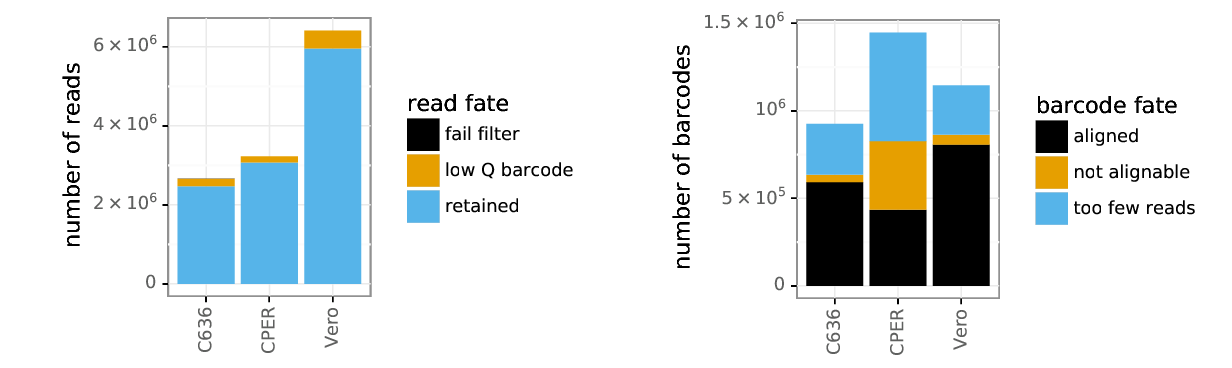

In [7]:
showPDF([countsplotprefix + 'readstats.pdf', countsplotprefix + 'bcstats.pdf'])

Here we see the typical number of reads per barcode. 
At the most efficient sequencing depth, we want most of the barcodes to be around 2 or 3.
So we see that we sequenced to probably the near-optimal depth for *CPER*, and to possibly a bit excessive depth for *Vero* and *C6/36* (although there is no downside to this other than wasted sequencing cost).

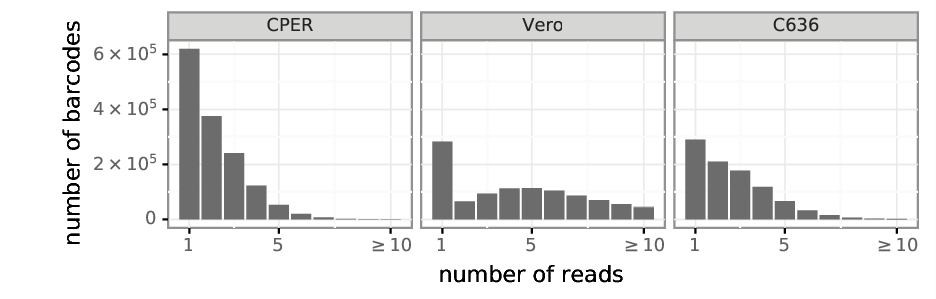

In [8]:
showPDF(countsplotprefix + 'readsperbc.pdf')

Here is the sequencing depth across the two subamplicons.
We can see that it is fairly even across both subamplicons as desired.

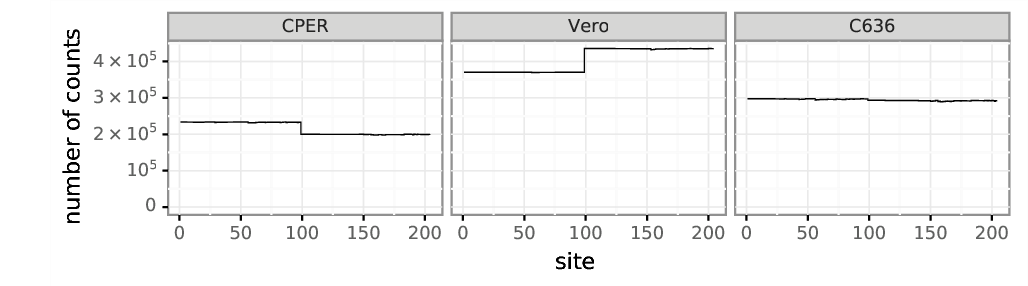

In [9]:
showPDF(countsplotprefix + 'depth.pdf')

Here is the mutation frequency at each site. 
You can see that we have large peaks at a few sites for both *Vero* and *C6/36* cells. 
This fact indicates that the libraries were strongly bottlenecked and a few variants effectively "won".
This would be a bad thing if our goal was to systematically identify all the best mutations, as there is probably some degree of randomness in which variants won.
However, if the goal is just to identify some mutations for experimental follow-up (as is the case in this study), this is not such a big problem as we can just focus on these high-frequency mutations and test their phenotypes (which is what was subsequently done).

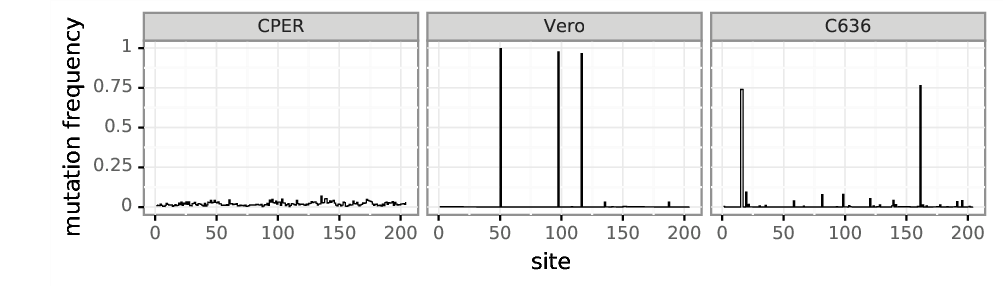

In [10]:
showPDF(countsplotprefix + 'mutfreq.pdf')

This plot shows the sampling of amino acids and codons in the libraries.
You can see that we have good sampling in the *CPER* library, meaning most mutations are present initially.
The diversity is greatly reduced in the *Vero* and *C6/36* cells due to selection and bottlenecking.

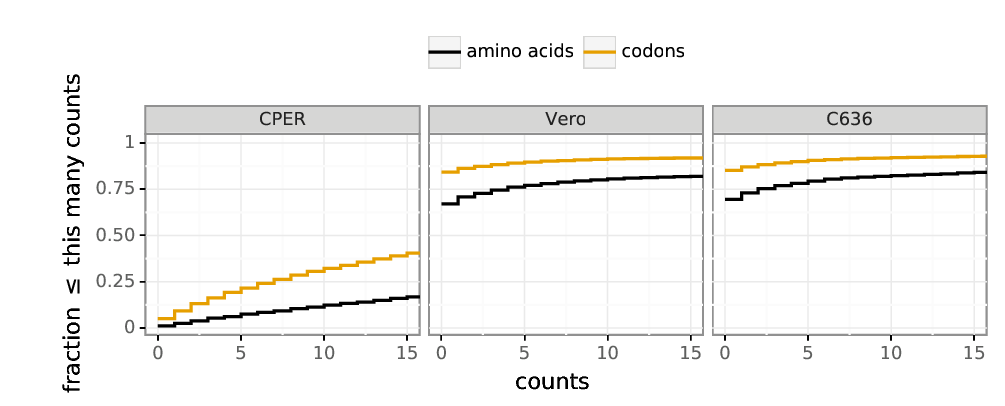

In [11]:
showPDF(countsplotprefix + 'cumulmutcounts.pdf')

This plot shows the mutation frequencies for each sample.
We actually only see a modest decrease in mutation frequency in the passaged viruses because although most mutations go down in frequency, a few go up to very high frequency. 
But we can see that the stop codons present in the *CPER* sample go away after passaging in *Vero* and or *C6/36* cells.

The middle panel for the *CPER* also shows that we had a good mix of 1-, 2-, and 3-nucleotide codon mutations in the initial *CPER* library.

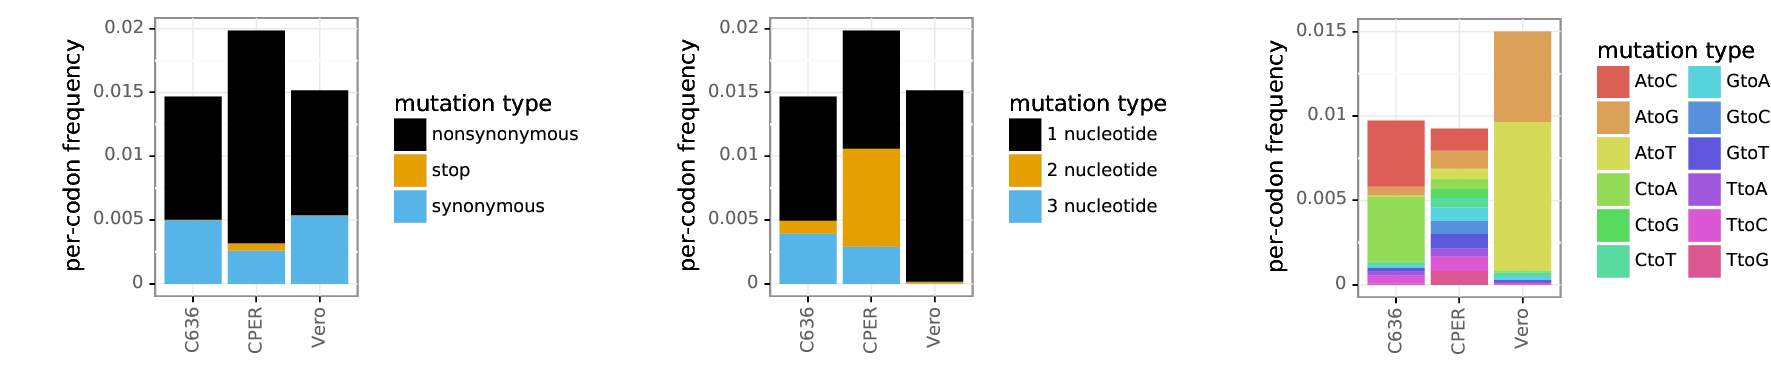

In [12]:
showPDF([countsplotprefix + 'codonmuttypes.pdf',
         countsplotprefix + 'codonntchanges.pdf',
         countsplotprefix + 'singlentchanges.pdf'])

## Align *CPER* sample to longer region of E protein 
The experiments did **not** include sequencing of unmutated DNA to estimate the sequencing error rate.
However, they did sequence an extra amplicon of the E protein in the region that was **not** mutagenized.
Therefore, we can plot the mutation rate over this longer region of E, and see the "mutation" rate over the unmutagenized region versus the mutagenized region.
We again do this using [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp), but now only use the *CPER* sample and align to the longer reference sequence in the file [./data/NatalEDIII.fa](./data/NatalEDIII.fa), which also contains a 5' region of E that was not mutagenized.


In [14]:
refseqlong = ' ./data/NatalEDIII.fa'


alignspecslong = ' '.join([
        '1,291,37,30',
        '292,585,36,28',
        '586,903,30,27'
        ])

countslongdir = os.path.join(resultsdir, 'codoncounts_longE')
if not os.path.isdir(countslongdir):
    os.mkdir(countslongdir)
    
countslongbatchfile = os.path.join(countslongdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples.query('name == "CPER"')[['name', 'R1']].to_html(index=False)))
samples.query('name == "CPER"')[['name', 'R1']].to_csv(countslongbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countslongbatchfile} \
        --refseq {refseqlong} \
        --alignspecs {alignspecslong} \
        --outdir {countslongdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 180 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 

print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,R1
CPER,CPER_R1.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


The plot we want to show here is the one that shows the mutation frequency along the gene.
It is below, and shows that the mutation rate is very low in the non-mutagenized regions, but then gets higher in the mutagenized regions.

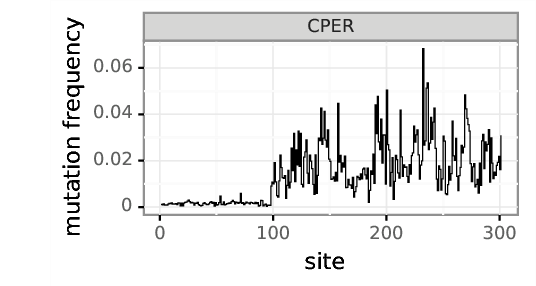

In [15]:
countslongplotprefix = os.path.join(countslongdir, 'summary_')
showPDF(countslongplotprefix + 'mutfreq.pdf')

## Differential selection in *Vero* and *C6/36* cells
We now compute the [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) for mutations in *C6/36* cells versus *Vero* cells.
We do this using [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html).

We compute the selection for *C6/36* relative to *Vero*, so positive differential selection values indicate mutations favored in *C6/36* cells relative to *Vero*, and negative values indicate the opposite.

In [22]:
diffseldir = os.path.join(resultsdir, 'diffsel')
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)
    
diffselbatchfile = os.path.join(diffseldir, 'batch.csv')

diffselbatch = pandas.DataFrame.from_records([
        ('C636-vs-Vero', 'C636', 'Vero')
        ],
        columns=['name', 'sel', 'mock'])

print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch.to_html(index=False)))

diffselbatch.to_csv(diffselbatchfile, index=False)

log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile} \
        --outdir {diffseldir} \
        --indir {countsdir} \
        --use_existing {use_existing}

Here is the batch file that we write to CSV format to use as input:


name,sel,mock
C636-vs-Vero,C636,Vero


Now we look at the differential selection:

In [34]:
diffselprefix = os.path.join(diffseldir, 'summary_')
diffsel = diffselprefix + 'meanmutdiffsel.csv'

Here is the site differential selection along the gene. 
There are a few big peaks which are probably sites of selected mutations.
But we should be careful over-interpreting this because of the lack of replicates and bottlenecking of diversity.
It is not supported to make statistical statements about which sites are and are not differentially selected, but certainly the big peaks represent reasonable candidate sites.

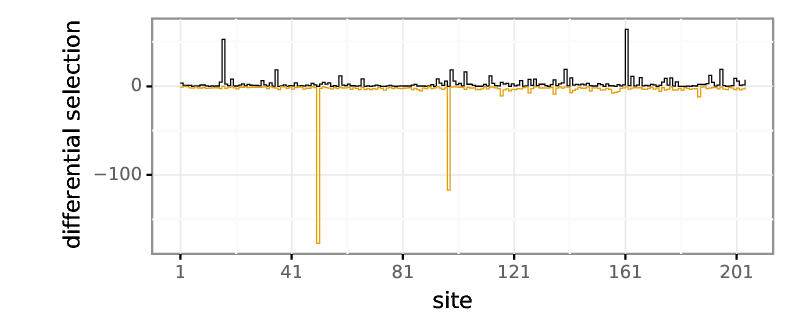

In [25]:
showPDF(diffselprefix + 'meantotaldiffsel.pdf')

Now lets show the data above in a logo plot across the entire gene.
We make this logo plot using [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html), and show the wildtype amino acid below the plot.
Letters above the line indicate mutations enriched in *C6/36* cells.

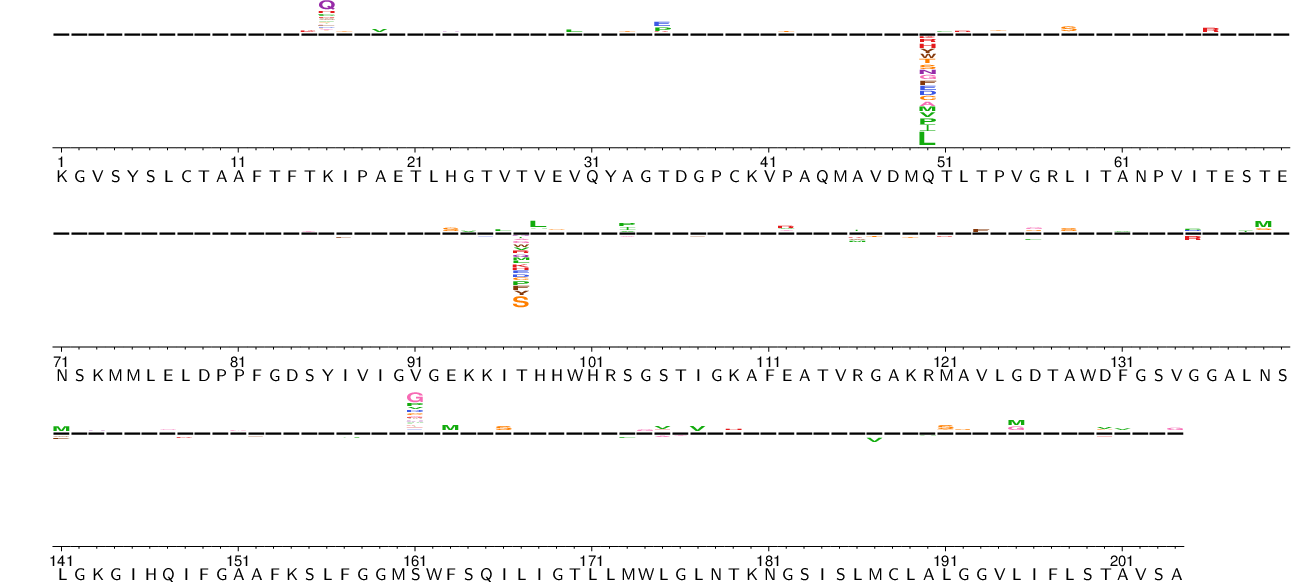

In [42]:
logoplot = os.path.join(diffseldir, 'full_diffsel.pdf')

log = !dms2_logoplot \
        --diffsel {diffsel} \
        --outdir {diffseldir} \
        --name full \
        --overlay1 {diffsel} wildtype wildtype \
        --underlay yes \
        --use_existing {use_existing}
        
showPDF(logoplot)

Now we'll make a plot where we zoom in on the sites of most prominent selection, which are 16, 50, 97, and 161 in sequential numbering of our reference sequence.
For each site, we'll also show the two flanking amino acids.
We make this plot using [dms_tools2.rplot.siteSubsetGGSeqLogo](https://jbloomlab.github.io/dms_tools2/dms_tools2.rplot.html#dms_tools2.rplot.siteSubsetGGSeqLogo).
These sites (and the top mutations) shown below are the best candidates for host-specific adaptive mutations, and are what were chosen for experimental follow up.

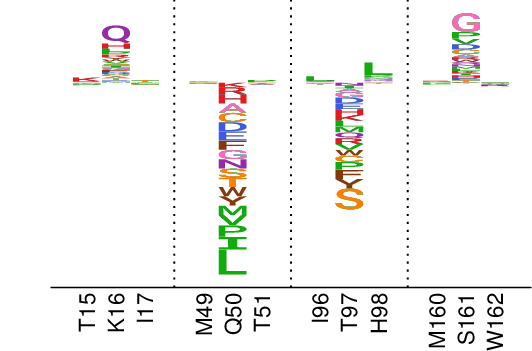

In [78]:
sites_to_show = set.union(*[{r - 1, r, r +1} for r in [16, 50, 97, 161]])

# extract sites to plot
mutdiffsel = (
              pandas.read_csv(diffsel)
              .assign(show=lambda x: x.site.isin(sites_to_show),
                      wtsite=lambda x: x.wildtype + x.site.astype('str'))
              .pivot_table(values='mutdiffsel', index=['site', 'wtsite', 'show'], columns='mutation')
              .fillna(0)
              .reset_index()
              .sort_values('site')
              .drop('site', axis=1)
              .rename(columns={'wtsite':'site'})
              )

zoomlogoplot = os.path.join(diffseldir, 'zoom_diffsel.pdf')

dms_tools2.rplot.siteSubsetGGSeqLogo(logodata=mutdiffsel,
                                     chars=dms_tools2.AAS,
                                     plotfile=zoomlogoplot,
                                     width=4,
                                     height=3,
                                     )

showPDF(zoomlogoplot)